# Capstone: West Nile Virus

![chicago](images/chiskyline.png)

reference: [Kaggle Challenge 2015](https://www.kaggle.com/c/predict-west-nile-virus)

- West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.
- By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.
- Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.
- Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus.

# Import packages and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import warnings
#import plotly

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

# import the private function for calcuating the weight of importance (WOE) to eliminate features of less intrest
# directly downloaded from the github link: https://github.com/pankajkalania/IV-WOE/blob/main/iv_woe_code.py
from pywoe.iv_woe_code import get_iv_woe

from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap
from scipy.special import softmax

warnings.filterwarnings("ignore")
%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Load Datasets

In [2]:
datadir = '../datasets'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored

## Datasets consist of Main, Spray, Weather, Map data:
- Main Data
    - test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 
- Spray Data
    - spraying to kill mosquitos.
    - the GIS data for their spray efforts in 2011 and 2013.
    - Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 
- Weather Data
    - It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.
    - dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 
- Map Data
    - primarily provided for use in visualizations

In [3]:
''' load the datasets '''

# load the main datasets that contain virus test results
train = pd.read_csv(os.path.join(datadir_pr, 'train_final.csv'), index_col=0)
target = pd.read_csv(os.path.join(datadir_pr, 'train_target.csv'), index_col=0)

In [4]:
train.head(3)

,Depart,Heat_1d,Heat_3d,Heat_7d,CodeSum_1d,PrecipTotal_1d,ResultDir_1d,ResultDir_3d,PrecipBool_7d
0,11.0,0.0,0.0,0.0,0.0,0.00,22.0,21.0,0.0
1,7.0,0.0,0.0,0.0,0.0,0.78,32.0,14.0,1.0
2,1.0,0.0,2.0,0.0,0.0,0.00,21.0,1.0,0.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1102 entries, 0 to 1101
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Depart          1102 non-null   float64
 1   Heat_1d         1102 non-null   float64
 2   Heat_3d         1102 non-null   float64
 3   Heat_7d         1102 non-null   float64
 4   CodeSum_1d      1102 non-null   float64
 5   PrecipTotal_1d  1102 non-null   float64
 6   ResultDir_1d    1102 non-null   float64
 7   ResultDir_3d    1102 non-null   float64
 8   PrecipBool_7d   1102 non-null   float64
dtypes: float64(9)
memory usage: 86.1 KB


In [6]:
target.sample(5)

,WnvPresent
415,0
125,0
68,0
636,1
66,0


In [7]:
''' target type conversion from dataframe to series '''
target = target.squeeze()

In [8]:
target.info()

<class 'pandas.core.series.Series'>
Int64Index: 1102 entries, 0 to 1101
Series name: WnvPresent
Non-Null Count  Dtype
--------------  -----
1102 non-null   int64
dtypes: int64(1)
memory usage: 17.2 KB


# Split the data into train & test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=23)

In [10]:
''' Check whether the data is equally splited '''
print('Virus Positive ratio')
print('train: {}'.format(y_train.sum()/len(y_train)))
print('test:  {}'.format(y_test.sum()/len(y_test)))

Virus Positive ratio
train: 0.5084306095979247
test:  0.48036253776435045


# Scaling

In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Model1: Logistic Regression

## Hyperparameter tuning w/ RandomizedSearchCV

In [12]:
model_logr = LogisticRegression(random_state=23)
kf = KFold(n_splits=6, shuffle=True, random_state=23)

# Create the parameter space
params = {"penalty": ["l1", "l2", "elasticnet", "none"],  # The norm of the penalty
         "tol": np.linspace(0.0001, 1.0, 50),  # Tolerance for stopping criteria
         "C": np.linspace(0.1, 1000.0, 50),  # Inverse of regularization strength
         "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Alogrithm to use in the optimization problem
         "max_iter": [500]} # maximum number of iteration 

# Instantiate the RandomizedSearchCV object
logr_cv = RandomizedSearchCV(model_logr, params, cv=kf, scoring='roc_auc')

# Fit the data to the model
logr_cv.fit(X_train_scaled, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters:")
print(logr_cv.best_params_)
print("*"*30)
print("Tuned Logistic Regression Best Accuracy Score: {}".format(logr_cv.best_score_))

Tuned Logistic Regression Parameters:
{'tol': 0.6735020408163265, 'solver': 'saga', 'penalty': 'l1', 'max_iter': 500, 'C': 489.84693877551024}
******************************
Tuned Logistic Regression Best Accuracy Score: 0.6206906712697899


## Check the model with the best parameter

In [13]:
model_logr = LogisticRegression(random_state=23, **logr_cv.best_params_)

model_logr.fit(X_train_scaled, y_train)

LogisticRegression(C=489.84693877551024, max_iter=500, penalty='l1',
                   random_state=23, solver='saga', tol=0.6735020408163265)

In [14]:
# model predict
y_pred_logr = model_logr.predict(X_test_scaled)

# predict probabilities
y_pred_probs_logr = model_logr.predict_proba(X_test_scaled)[:,1]

#print(y_pred_probs_logr[:10])

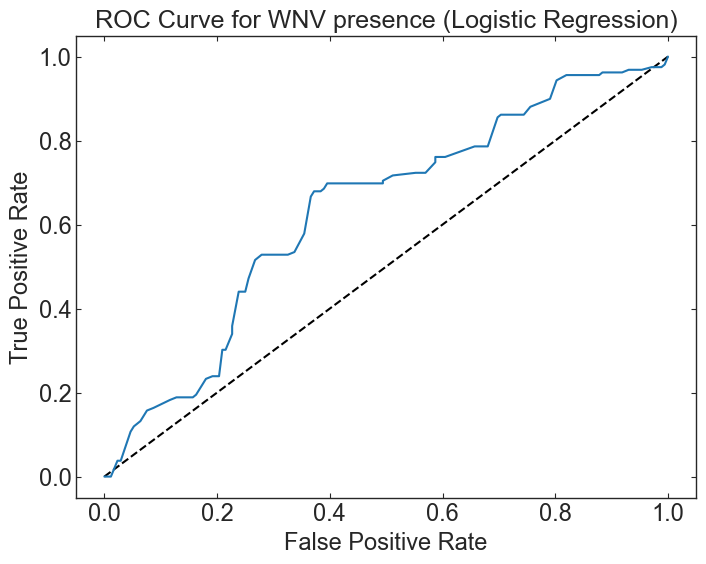

In [15]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr_logr, tpr_logr, thresholds = roc_curve(y_test, y_pred_probs_logr)

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], 'k--')

ax.plot(fpr_logr, tpr_logr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for WNV presence (Logistic Regression)', fontsize=18);

In [16]:
# Calculate roc_auc_score
logr_best_score = roc_auc_score(y_test, y_pred_probs_logr)
print("ROC AUC score: {:.2f}".format(logr_best_score))

# Calculate the confusion matrix
print("*"*10 + "  Confusion Matrix  " + "*"*10)
print(confusion_matrix(y_test, y_pred_logr))

# Calculate the classification report
print("*"*10 + "  Classification Report  " + "*"*10)
print(classification_report(y_test, y_pred_logr))

ROC AUC score: 0.63
**********  Confusion Matrix  **********
[[ 97  75]
 [ 48 111]]
**********  Classification Report  **********
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       172
           1       0.60      0.70      0.64       159

    accuracy                           0.63       331
   macro avg       0.63      0.63      0.63       331
weighted avg       0.63      0.63      0.63       331



# Model2: Random Forest 

## Hyperparameter tuning w/ RandomizedSearchCV

In [17]:
model_randf = RandomForestClassifier(random_state=23)
kf = KFold(n_splits=6, shuffle=True, random_state=23)

# Create the parameter space
params = {'n_estimators': [int(x) for x in np.linspace(10,100,10)], # number of trees
          'criterion': ['gini', 'entropy', 'log_loss'], # measure the quality of a split
          'max_features': ['auto', 'sqrt'], # The number of features to consider
          'max_depth': [2, 4, None], # maximum depth of the tree
          'min_samples_split': [2, 5], # minimum number of samples to split an internal node
          'min_samples_leaf': [1, 2], # minimum number of samples required to be a leaf node
          'bootstrap': [True, False]} # whether bootstrap samples are used when building trees

# Instantiate the RandomizedSearchCV object
randf_cv = RandomizedSearchCV(model_randf, params, cv=kf, scoring='roc_auc')

# Fit the data to the model
randf_cv.fit(X_train_scaled, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters:")
print(randf_cv.best_params_)
print("*"*30)
print("Tuned Random Forest Best Accuracy Score: {}".format(randf_cv.best_score_))

Tuned Random Forest Parameters:
{'n_estimators': 40, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
******************************
Tuned Random Forest Best Accuracy Score: 0.7604416622506234


## Check the model with the best parameter

In [18]:
model_randf= RandomForestClassifier(random_state=23, **randf_cv.best_params_)

model_randf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=40, random_state=23)

In [19]:
# model predict
y_pred_randf = model_randf.predict(X_test_scaled)

# predict probabilities
y_pred_probs_randf = model_randf.predict_proba(X_test_scaled)[:,1]

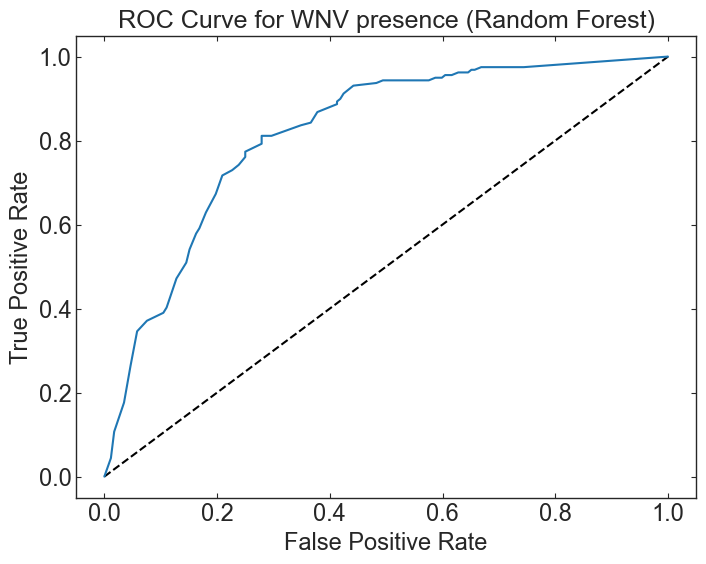

In [20]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr_randf, tpr_randf, thresholds = roc_curve(y_test, y_pred_probs_randf)

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], 'k--')

ax.plot(fpr_randf, tpr_randf)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for WNV presence (Random Forest)', fontsize=18);

In [21]:
# Calculate roc_auc_score
randf_best_score = roc_auc_score(y_test, y_pred_probs_randf)
print("ROC AUC score: {:.2f}".format(randf_best_score))

# Calculate the confusion matrix
print("*"*10 + "  Confusion Matrix  " + "*"*10)
print(confusion_matrix(y_test, y_pred_randf))

# Calculate the classification report
print("*"*10 + "  Classification Report  " + "*"*10)
print(classification_report(y_test, y_pred_randf))

ROC AUC score: 0.82
**********  Confusion Matrix  **********
[[124  48]
 [ 30 129]]
**********  Classification Report  **********
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       172
           1       0.73      0.81      0.77       159

    accuracy                           0.76       331
   macro avg       0.77      0.77      0.76       331
weighted avg       0.77      0.76      0.76       331



# Model3: Naive Bayes

## Hyperparameter tuning w/ RandomizedSearchCV

In [22]:
model_bayes = GaussianNB()
kf = KFold(n_splits=6, shuffle=True, random_state=23)

# Create the parameter space
params = {'var_smoothing': np.logspace(-9,-5,5)}   # Portion of the largest variance of all features

# Instantiate the RandomizedSearchCV object
bayes_cv = RandomizedSearchCV(model_bayes, params, cv=kf, scoring='roc_auc')

# Fit the data to the model
bayes_cv.fit(X_train_scaled, y_train)

# Print the tuned parameters and score
print("Tuned Gaussian Naive Bayes Parameters:")
print(bayes_cv.best_params_)
print("*"*30)
print("Tuned Gaussian Naive Bayes Best Accuracy Score: {}".format(bayes_cv.best_score_))

Tuned Gaussian Naive Bayes Parameters:
{'var_smoothing': 1e-09}
******************************
Tuned Gaussian Naive Bayes Best Accuracy Score: 0.6415350441569705


## Check the model with the best parameter

In [23]:
model_bayes= GaussianNB(**bayes_cv.best_params_)

model_bayes.fit(X_train_scaled, y_train)

GaussianNB()

In [24]:
# model predict
y_pred_bayes = model_bayes.predict(X_test_scaled)

# predict probabilities
y_pred_probs_bayes = model_bayes.predict_proba(X_test_scaled)[:,1]

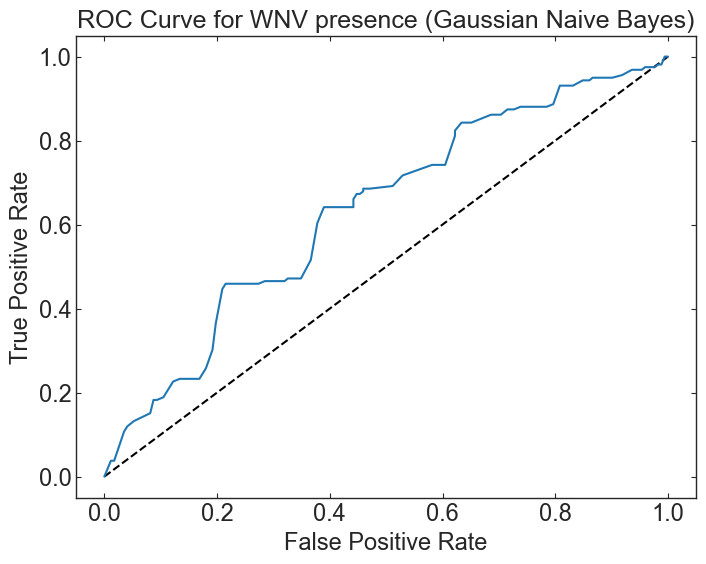

In [25]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr_bayes, tpr_bayes, thresholds = roc_curve(y_test, y_pred_probs_bayes)

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], 'k--')

ax.plot(fpr_bayes, tpr_bayes)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for WNV presence (Gaussian Naive Bayes)', fontsize=18);

In [26]:
# Calculate roc_auc_score
bayes_best_score = roc_auc_score(y_test, y_pred_probs_bayes)
print("ROC AUC score: {:.2f}".format(bayes_best_score))

# Calculate the confusion matrix
print("*"*10 + "  Confusion Matrix  " + "*"*10)
print(confusion_matrix(y_test, y_pred_bayes))

# Calculate the classification report
print("*"*10 + "  Classification Report  " + "*"*10)
print(classification_report(y_test, y_pred_bayes))

ROC AUC score: 0.63
**********  Confusion Matrix  **********
[[ 41 131]
 [ 19 140]]
**********  Classification Report  **********
              precision    recall  f1-score   support

           0       0.68      0.24      0.35       172
           1       0.52      0.88      0.65       159

    accuracy                           0.55       331
   macro avg       0.60      0.56      0.50       331
weighted avg       0.60      0.55      0.50       331



# Model4: Support Vector Machine

## Hyperparameter tuning w/ RandomizedSearchCV

In [27]:
model_svm = SVC(random_state=23)
kf = KFold(n_splits=6, shuffle=True, random_state=23)

# Create the parameter space
params = {"C": np.linspace(0.1, 1000.0, 50),  # Regularization parameter
          "tol": np.linspace(0.0001, 1.0, 50),  # Tolerance for stopping criteria
          'gamma': np.logspace(0, -4, 5),  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
          'kernel': ['linear','poly','rbf','sigmoid']}  # kernel types

# Instantiate the RandomizedSearchCV object
svm_cv = RandomizedSearchCV(model_svm, params, cv=kf, scoring='roc_auc')

# Fit the data to the model
svm_cv.fit(X_train_scaled, y_train)

# Print the tuned parameters and score
print("Tuned Support Vector Machine Parameters:")
print(svm_cv.best_params_)
print("*"*30)
print("Tuned Support Vector Machine Best Accuracy Score: {}".format(svm_cv.best_score_))

Tuned Support Vector Machine Parameters:
{'tol': 0.9795938775510205, 'kernel': 'poly', 'gamma': 1.0, 'C': 122.53673469387755}
******************************
Tuned Support Vector Machine Best Accuracy Score: 0.7261760945453769


## Check the model with the best parameter

In [28]:
model_svm = SVC(random_state=23, probability=True, **svm_cv.best_params_)

model_svm.fit(X_train_scaled, y_train)

SVC(C=122.53673469387755, gamma=1.0, kernel='poly', probability=True,
    random_state=23, tol=0.9795938775510205)

In [29]:
# model predict
y_pred_svm = model_svm.predict(X_test_scaled)

# predict probabilities
y_pred_probs_svm = model_svm.predict_proba(X_test_scaled)[:,1]

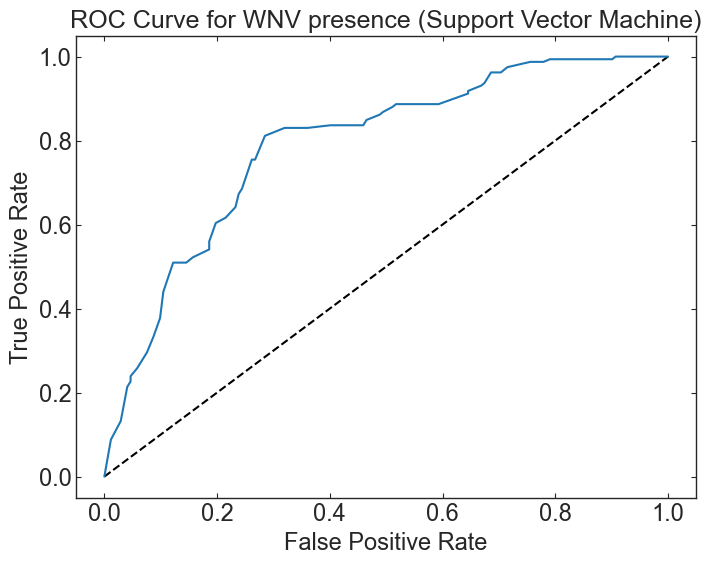

In [30]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr_svm, tpr_svm, thresholds = roc_curve(y_test, y_pred_probs_svm)

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], 'k--')

ax.plot(fpr_svm, tpr_svm)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for WNV presence (Support Vector Machine)', fontsize=18);

In [31]:
# Calculate roc_auc_score
svm_best_score = roc_auc_score(y_test, y_pred_probs_svm)
print("ROC AUC score: {:.2f}".format(svm_best_score))

# Calculate the confusion matrix
print("*"*10 + "  Confusion Matrix  " + "*"*10)
print(confusion_matrix(y_test, y_pred_svm))

# Calculate the classification report
print("*"*10 + "  Classification Report  " + "*"*10)
print(classification_report(y_test, y_pred_svm))

ROC AUC score: 0.79
**********  Confusion Matrix  **********
[[123  49]
 [ 30 129]]
**********  Classification Report  **********
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       172
           1       0.72      0.81      0.77       159

    accuracy                           0.76       331
   macro avg       0.76      0.76      0.76       331
weighted avg       0.77      0.76      0.76       331



# Model5: K-Nearest Neighbors

## Hyperparameter tuning w/ RandomizedSearchCV

In [32]:
model_knn = KNeighborsClassifier()
kf = KFold(n_splits=6, shuffle=True, random_state=23)

# Create the parameter space
params = {"n_neighbors": np.arange(3,30),  # number of neighbors
          "leaf_size": np.arange(1,50),  # leaf size passed to tree
          "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],  # algorithm used to compute the nearest neighbors
          "p": [1, 2]} # Power parameter for the Minkowski metric

# Instantiate the RandomizedSearchCV object
knn_cv = RandomizedSearchCV(model_knn, params, cv=kf, scoring='roc_auc')

# Fit the data to the model
knn_cv.fit(X_train_scaled, y_train)

# Print the tuned parameters and score
print("Tuned K-Nearest Neighbors Parameters:")
print(knn_cv.best_params_)
print("*"*30)
print("Tuned K-Nearest Neighbors Best Accuracy Score: {}".format(knn_cv.best_score_))

Tuned K-Nearest Neighbors Parameters:
{'p': 1, 'n_neighbors': 11, 'leaf_size': 40, 'algorithm': 'ball_tree'}
******************************
Tuned K-Nearest Neighbors Best Accuracy Score: 0.7339403512989167


## Check the model with the best parameter

In [33]:
model_knn = KNeighborsClassifier(**knn_cv.best_params_)

model_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=40, n_neighbors=11, p=1)

In [34]:
# model predict
y_pred_knn = model_knn.predict(X_test_scaled)

# predict probabilities
y_pred_probs_knn = model_knn.predict_proba(X_test_scaled)[:,1]

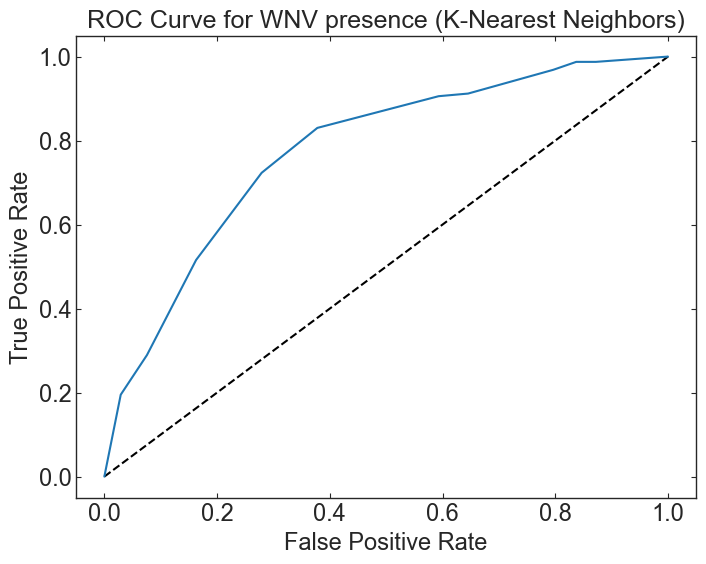

In [35]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_pred_probs_knn)

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], 'k--')

ax.plot(fpr_knn, tpr_knn)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for WNV presence (K-Nearest Neighbors)', fontsize=18);

In [36]:
# Calculate roc_auc_score
knn_best_score = roc_auc_score(y_test, y_pred_probs_knn)
print("ROC AUC score: {:.2f}".format(knn_best_score))

# Calculate the confusion matrix
print("*"*10 + "  Confusion Matrix  " + "*"*10)
print(confusion_matrix(y_test, y_pred_knn))

# Calculate the classification report
print("*"*10 + "  Classification Report  " + "*"*10)
print(classification_report(y_test, y_pred_knn))

ROC AUC score: 0.78
**********  Confusion Matrix  **********
[[107  65]
 [ 27 132]]
**********  Classification Report  **********
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       172
           1       0.67      0.83      0.74       159

    accuracy                           0.72       331
   macro avg       0.73      0.73      0.72       331
weighted avg       0.74      0.72      0.72       331



# Compare the best models

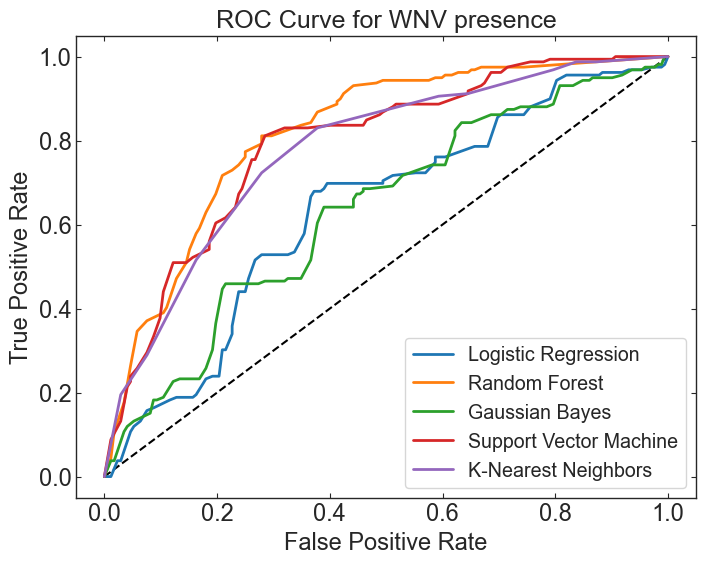

In [37]:
# Compare the ROC curves
fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], 'k--')

lw = 2 # line width
ax.plot(fpr_logr, tpr_logr, lw=lw, label='Logistic Regression')
ax.plot(fpr_randf, tpr_randf, lw=lw, label='Random Forest')
ax.plot(fpr_bayes, tpr_bayes, lw=lw, label='Gaussian Bayes')
ax.plot(fpr_svm, tpr_svm, lw=lw, label='Support Vector Machine')
ax.plot(fpr_knn, tpr_knn, lw=lw, label='K-Nearest Neighbors')
ax.legend(loc='best', fontsize='small')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for WNV presence', fontsize=18);

In [38]:
model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Support Vector Machine', 'K-Nearest Neighbors']
auc_scores  = [logr_best_score, randf_best_score, bayes_best_score, svm_best_score, knn_best_score]

df_model_scores = pd.DataFrame(list(zip(model_names, auc_scores)), columns=['model','auc_score'])
df_model_scores

,model,auc_score
0,Logistic Regression,0.634068
1,Random Forest,0.817427
2,Naive Bayes,0.633739
3,Support Vector Machine,0.790204
4,K-Nearest Neighbors,0.775742


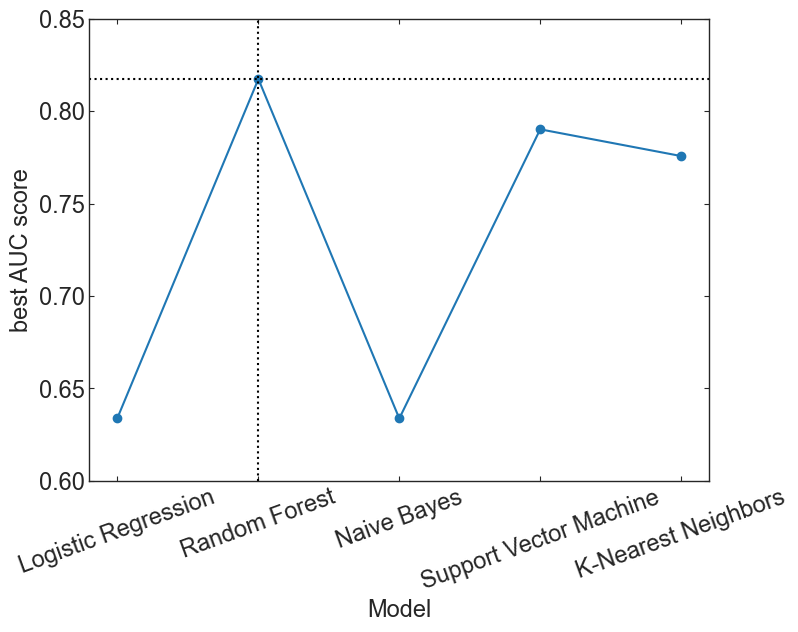

In [39]:
best_score = df_model_scores.auc_score.max()
best_model = df_model_scores.loc[df_model_scores.auc_score==df_model_scores.auc_score.max(), 'model'].values[0]

fig, ax = plt.subplots()

ax.plot(df_model_scores.model, df_model_scores.auc_score, 'o-')
ax.tick_params(axis='x', rotation=20)
ax.set_ylim(0.6,0.85)
ax.set(xlabel='Model', ylabel='best AUC score')

ax.axhline(y=best_score, linestyle=':', color='k')
ax.axvline(x=best_model, linestyle=':', color='k');

> From the benchmark, we can find that **Random Forest** shows best performance as it has a highest AUC score among the models.

# SHAP Analysis
- SHapley Additive exPlanations (SHAP): a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.
- reference: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

<div class="alert alert-warning">
<b>Note:</b>

- while SHAP shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.
</div>

In [40]:
# our best model is Random Forest one
model_best = model_randf

In [41]:
# Fits the explainer
explainer = shap.Explainer(model_best.predict, X_test_scaled)

# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_scaled)

# if only interested in the SHAP values: 
#shap_values = explainer.shap_values(X_test_scaled)

# rename the features (since the feature names were removed in the scaled data)
shap_values.feature_names = X_test.columns.values.tolist()

Exact explainer: 332it [00:30,  7.97it/s]                                                                                                                                                                   


> The `shap_values` variable will have three attributes: `.values`, `.base_values` and `.data`
> - `.data`: simply a copy of the input data
> - `.base_values`: expected value of the target
> - `.values`: SHAP values for each example

In [42]:
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

## Global effects

### Bar plot

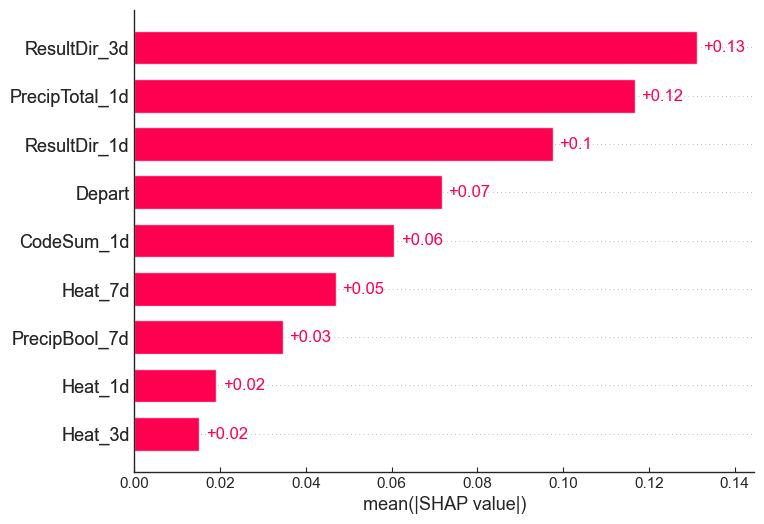

In [43]:
shap.plots.bar(shap_values)

### Beeswarm plot

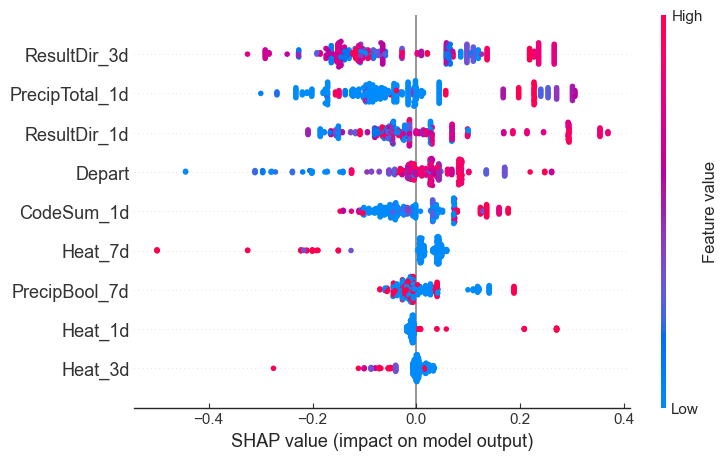

In [44]:
#shap.summary_plot(shap_values)
shap.plots.beeswarm(shap_values)

### Violin plot

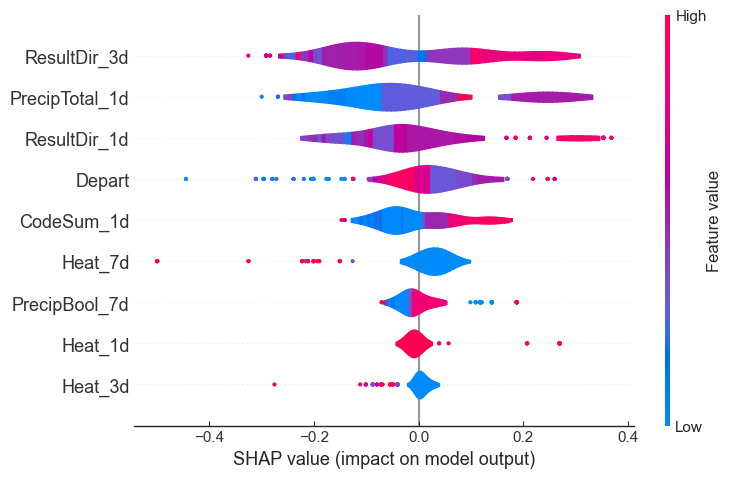

In [45]:
shap.summary_plot(shap_values, plot_type='violin')

> The SHAP analysis shows that
> - the wind resultant direction at 3 days before (`ResultDir_3d`) affects the result most significantly.
> - the precipitation at 1 day before (`PrecipTotal_1d`), the wind resultant direction at 1 day before (`ResultDir_1d`), the departure from normal condition (`Depart`), and the indicator of the weather at the previous day (`CodeSum_1d`) also key features that affect the result considerably. 
> - the Heating (`Heat_1/3/7d`) has small influence, while `Heat_7d` has very strong negative value when its value is high. 

## Local effects

In [46]:
n_obs = 10 # specific observation number to be checked

### Local Bar plot

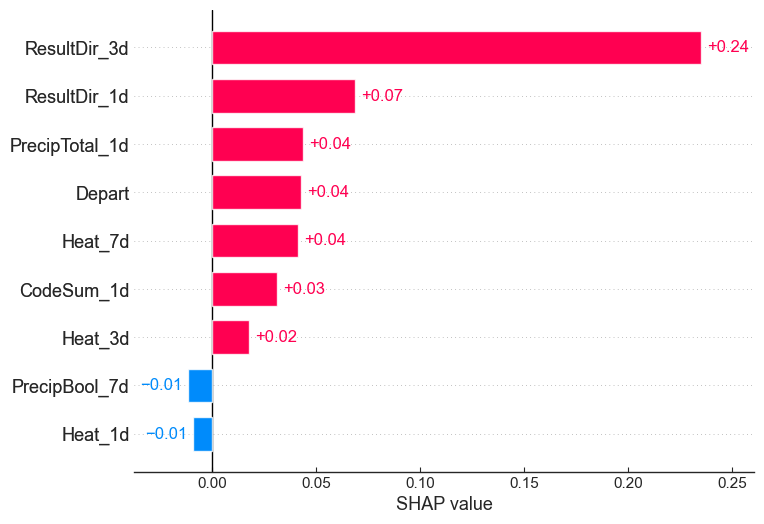

In [47]:
n_obs = 10
shap.plots.bar(shap_values[n_obs])

### Waterfall plot

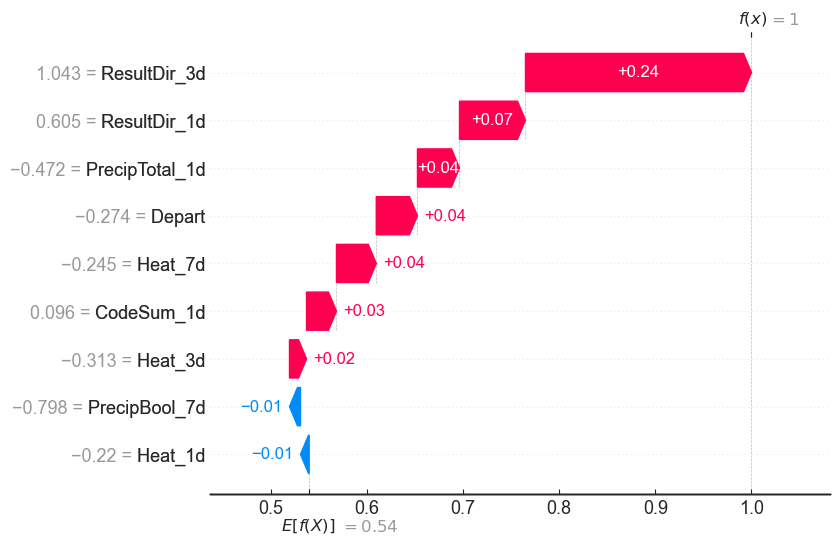

In [48]:
shap.plots.waterfall(shap_values[n_obs])

### Force plot

In [50]:
shap.initjs()
shap.plots.force(shap_values[n_obs])

# Conclusion

- We performed 5 different models with the finalized dataset, which are *Logistic Regression, Random Forest, Gaussian Naive Bayes, Support Vector Machine, and K-Nearest Neighbors.*
- The best model among them is ***Random Forest***, which has the highest AUC score. 
- The SHAP Analysis shows that
    - the wind resultant direction at 3 days before (ResultDir_3d) affects the result most significantly.
    - the precipitation at 1 day before (PrecipTotal_1d), the wind resultant direction at 1 day before (ResultDir_1d), the departure from normal condition (Depart), and the indicator of the weather at the previous day (CodeSum_1d) also key features that affect the result considerably.
    - the Heating (Heat_1/3/7d) has small influence, while Heat_7d has very strong negative value when its value is high.
- The analysis tells us that
    - in general, the wind direction and humidity (or rain) give considerable impact on the presence of the West Nile virus (likely also on the number of mosquitos that carry the virus).
    - We need further study how the wind direction affects the virus spread, but we suspect that the wind from the certain direction contains more wet air within the flow. 
    - The best condition that increase the number of mosquitos which may carry the virus would be the wet and warm air condition. 
    - high temperature may not be key feature that we have to consider for the virus spread. 